In [3]:
import psycopg2
import matplotlib.pyplot as plt

In [4]:
conn = psycopg2.connect("dbname=project user=hugens")
cursor_psql = conn.cursor()

In [5]:
#scale = 1/30000
scale = 1

In [6]:
sql = "select st_astext(point) from stops"
cursor_psql.execute(sql)
results = cursor_psql.fetchall()
#results

In [5]:
xs_stops = []
ys_stops = []
for row in results:
    point_string = row[0]
    point_string = point_string[6:-1]
    (x,y) = point_string.split()
    xs_stops.append(float(x))
    ys_stops.append(float(y))
print(xs_stops[:5])
print(ys_stops[:5])

[-8.5288333, -8.5588777, -8.5297784, -8.53830549, -8.53824995]
[41.20608334, 41.21944054, 41.20899437, 41.21027777, 41.21016667]


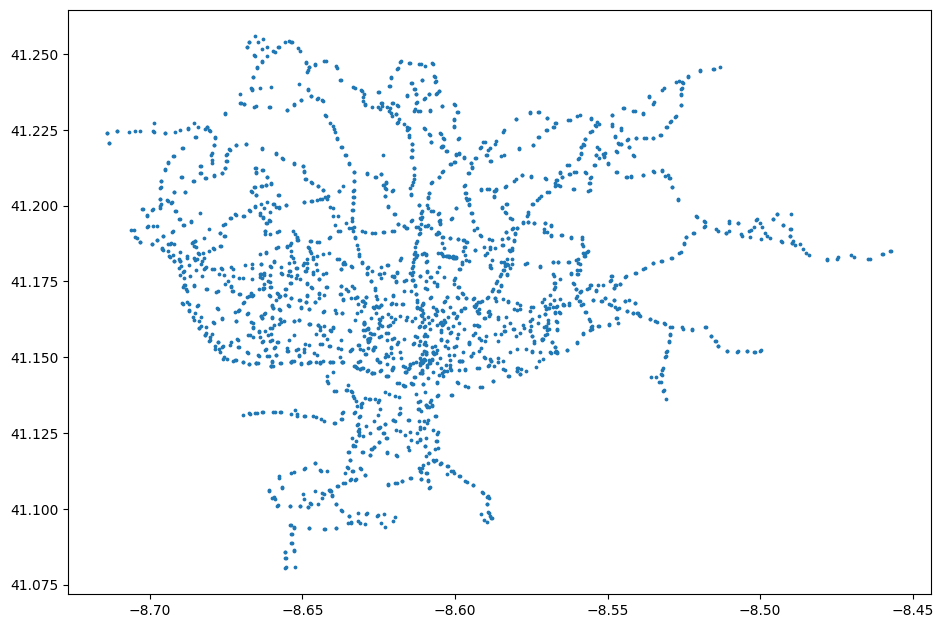

In [6]:
width_in_inches = ((max(xs_stops)-min(xs_stops))/0.0254)*1.1
height_in_inches = ((max(ys_stops)-min(ys_stops))/0.0254)*1.1
fig = plt.figure(figsize=(width_in_inches*scale, height_in_inches*scale))
plt.scatter(xs_stops,ys_stops,s=3)

In [20]:
conn = psycopg2.connect("dbname=project user=hugens")
cursor_psql = conn.cursor()
sql = "select stop_times.trip_id, stop_times.stop_id, st_astext(stops.point) from stops join stop_times on stops.stop_id = stop_times.stop_id"
cursor_psql.execute(sql)
results = cursor_psql.fetchall()
results[:5]

[('106_1_A_1', 'FRC', 'POINT(-8.6523635 41.08092721)'),
 ('106_1_A_1', 'FRCL2', 'POINT(-8.65552954 41.08066201)'),
 ('106_1_A_1', 'ISG2', 'POINT(-8.65546307 41.08371326)'),
 ('106_1_A_1', 'ACBL2', 'POINT(-8.65571403 41.0857182)'),
 ('106_1_A_1', 'VGM2', 'POINT(-8.6528143 41.08617544)')]

In [30]:
routes = {}
for trip_id, stop_times, point in results:
    routes[trip_id] = []
for trip_id, stop_times, point in results:
    routes[trip_id].append(point)

new_routes = {}
for trip_id, points_list in routes.items():
    xs = []
    ys = []
    for point in points_list:
        (x,y) = point[6:-1].split()
        xs.append(float(x))
        ys.append(float(y))
    new_routes[trip_id] = [xs,ys]
#new_routes

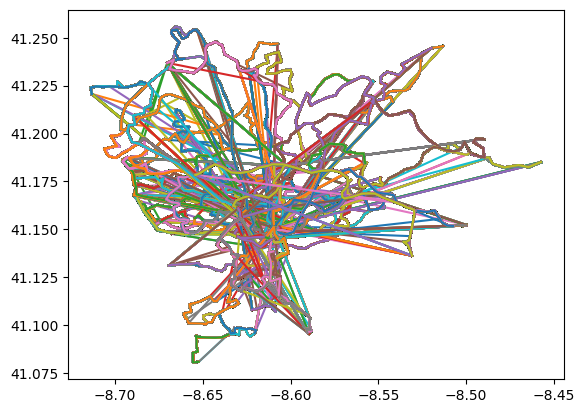

<Figure size 0.0180197x0.00688149 with 0 Axes>

In [33]:
scale = 1/30000
for trip_id, route in new_routes.items():
    xs, ys = route
    plt.plot(xs,ys)

width_in_inches = ((max(xs)-min(xs))/0.0254)*1.1
height_in_inches = ((max(ys)-min(ys))/0.0254)*1.1
fig = plt.figure(figsize=(width_in_inches*scale, height_in_inches*scale))
plt.show()

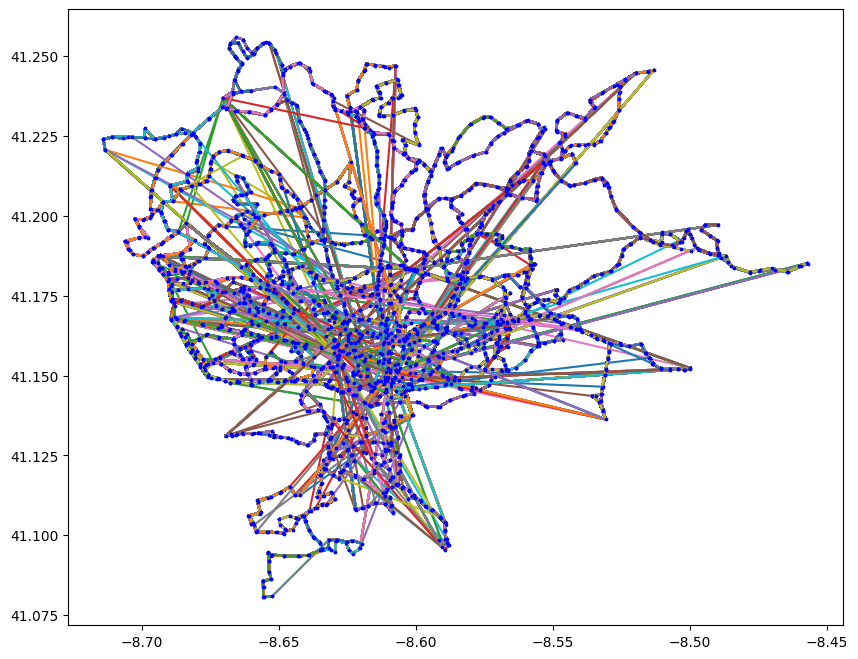

In [51]:
conn = psycopg2.connect("dbname=project user=hugens")
cursor_psql = conn.cursor()

# 1st query
sql = "select st_astext(point) from stops"
cursor_psql.execute(sql)
results0 = cursor_psql.fetchall()

xs_stops = []
ys_stops = []
for row in results0:
    point_string = row[0]
    point_string = point_string[6:-1]
    (x,y) = point_string.split()
    xs_stops.append(float(x))
    ys_stops.append(float(y))

# 2nd query
sql = "select stop_times.trip_id, stop_times.stop_id, st_astext(stops.point) from stops join stop_times on stops.stop_id = stop_times.stop_id"
cursor_psql.execute(sql)
results1 = cursor_psql.fetchall()

routes = {}
for trip_id, stop_times, point in results:
    routes[trip_id] = []
for trip_id, stop_times, point in results:
    routes[trip_id].append(point)

new_routes = {}
for trip_id, points_list in routes.items():
    xs = []
    ys = []
    for point in points_list:
        (x,y) = point[6:-1].split()
        xs.append(float(x))
        ys.append(float(y))
    new_routes[trip_id] = [xs,ys]

#scale = 1
#width_in_inches = ((max(xs)-min(xs))/0.0254)*1.1
#height_in_inches = ((max(ys)-min(ys))/0.0254)*1.1
#fig = plt.figure(figsize=(width_in_inches*scale, height_in_inches*scale))
fig = plt.figure(figsize=(10,8))

for trip_id, route in new_routes.items():
    xs, ys = route
    plt.plot(xs,ys)

plt.scatter(xs_stops,ys_stops,s=3, color='blue', zorder=2)
plt.show()

In [ ]:
sql = "select st_astext(st_simplify(proj_boundary,10)) from cont_aad_caop2018 where distrito='PORTO'"